<h2>Imports</h2>

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from copy import copy
from optical_center import getOpticalCenter

<h2>Utils

In [2]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


def get_nth_maximum(arr,n):
    uniqueValues = list(arr.flatten())
    uniqueValues.sort()
    if len(uniqueValues) < n:
        return uniqueValues[0]
    return uniqueValues[len(uniqueValues)-n]
    # sortedmatrix.sort()
    # # print(arr.shape)
    # if sortedmatrix.size == 0:
    #     return -1
    # return sortedmatrix[0 if n > sortedmatrix.size else -n] 

def get_optical_axis(projectionMat):
    return np.array([projectionMat[2][0],projectionMat[2][1],projectionMat[2][2],0])

<h2>Constants</h2>

In [3]:
datasetPath = "Data/dinoSparseRing/"
ß1 = 2
ß2 = 32
µ = 5       # the projection of one of its edges into R(p) is parallel to the image rows, and the smallest axis-aligned square containingits image covers a µ × µ pixel^2 area
# We associate with p a reference image R(p),the images S(p) where p should be visible and the images T(p) where it is truly found 

cosMinAngle = np.math.cos(np.math.radians(20))
cosMaxAngle = np.math.cos(np.math.radians(60))

patchModel = {
    "R":None,
    "S":set,
    "T":set
}
# The cell C(i, j) keeps track of two different sets Qt(i, j) and Qf(i, j)
cell = {
    "Qt":set,
    "Qf":set
}
# We associate with each image I a regular grid of β1×β1 pixel^2 cells
imageModel = {
    "image":None,
    "projMat":None,
    "optCenter":None,
    "grid":None,
    "dog":None,
    "harris":None,
    "sparseDog":None,
    "sparseHarris":None,
    "dogPositions":None,
    "harrisPositions":None
}

<h2>Get Input

In [4]:
# Initialize image model from a given path
def init_imgs(datasetPath):
    # Read imgs
    imgs = [cv.imread(file) for file in glob(datasetPath+'*.png')]
    # imgs = [cv.rotate(cv.imread(file),cv.ROTATE_90_COUNTERCLOCKWISE) for file in glob(datasetPath+'*.png')]

    # Construct corresponding image grid
    grids = [np.array([np.array([cell for x in range(0,img.shape[1]//ß1)]) for y in range(0,img.shape[0]//ß1)]) for img in imgs]

    return imgs,grids
    
# Read camera parameters and return the projection matrices for all pictures
def read_parameters_file(datasetPath):
    inputFile = open(datasetPath+"dinoSR_par.txt")
    lines = inputFile.readlines()
    lines.pop(0) # drop images number
    projections = []
    optAxes = []
    # Every line is a parameters list for the corresponding image camera
    for line in lines:
        line = line[:-1]                # \n character
        linedata = line.split(' ')
        imgName = linedata.pop(0)
        k = np.zeros((3,3))
        r = np.zeros((3,3))
        t = np.zeros((3,1))

        i = 0
        for ridx,row in enumerate(k):
            t[ridx][0]=linedata[ridx+18]
            for colidx,_ in enumerate(row):
                k[ridx][colidx]=linedata[i]
                r[ridx][colidx]=linedata[i+9]
                i+=1
        x = np.concatenate((r,t),axis=1)
        p = np.matmul(k,x)
        projections.append(p)

        optAxis = get_optical_axis(p)
        optAxis *= np.linalg.det(p[:,:-1])
        norm = np.linalg.norm(optAxis)
        # optAxis[3] = p[2][3]
        optAxis /= norm
        optAxes.append(optAxis)

        outputFile = open(datasetPath+"projection/projection"+imgName[6:10]+".txt",mode="w+")
        outputFile.write("CONTOUR\n")
        pString = ""
        for row in p:
            for col in row:
                pString += str('{0:0.5f}'.format(col))+" "
            pString += "\n"
        outputFile.write(pString)
        outputFile.close()
        
    return projections,optAxes

<h2>Feature Detection

In [5]:
# Get Harris and DoG operators for a given image
def get_dog_harris(img):
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
            
    # Get DoG
    g1 = cv.GaussianBlur(gray,(0,0),sigmaX=1)
    g2 = cv.GaussianBlur(gray,(0,0),sigmaX=1*np.sqrt(2))
    diff = cv.absdiff(g1,g2)
    dog = diff * gray

    # Get Harris
    bSize = 3
    kSize = 1
    corners = cv.cornerHarris(src=gray,blockSize=bSize,ksize=kSize,k=0.06)
    # corners = cv.dilate(corners,None)
    
    return dog , corners


def sparse_dog_harris(dog,harris):
    n = 4
    sparseDog = copy(dog)
    sparseHarris = copy(harris)
    sparseDogPositions = []
    sparseHarrisPositions = []
    for yIdx in range(0,len(dog),ß2):
        for xIdx in range(0,len(dog[0]),ß2):
            nThMaximumDog = get_nth_maximum(dog[yIdx:yIdx+ß2,xIdx:xIdx+ß2],n)
            if nThMaximumDog != -1:
                found = False
                for rowIdx,row in enumerate(dog[yIdx:yIdx+ß2]):
                    for columnIdx,column in enumerate(row[xIdx:xIdx+ß2]):
                        if not found and column == nThMaximumDog:
                            found = True
                            if column != 0:
                                sparseDogPositions.append((xIdx+columnIdx,yIdx+rowIdx))
                        else:
                            sparseDog[yIdx+rowIdx,xIdx+columnIdx] = 0
                # sparseDog[yIdx:yIdx+ß2,xIdx:xIdx+ß2] = sparseDog[yIdx:yIdx+ß2,xIdx:xIdx+ß2]*(sparseDog[yIdx:yIdx+ß2,xIdx:xIdx+ß2] == nThMaximumDog)
            nThMaximumHarris = get_nth_maximum(harris[yIdx:yIdx+ß2,xIdx:xIdx+ß2],n)
            if nThMaximumHarris != -1:
                found = False
                for rowIdx,row in enumerate(harris[yIdx:yIdx+ß2]):
                    for columnIdx,column in enumerate(row[xIdx:xIdx+ß2]):
                        if not found and column == nThMaximumHarris:
                            found = True
                            if column != 0:
                                sparseHarrisPositions.append((xIdx+columnIdx,yIdx+rowIdx))
                        else:
                            sparseHarris[yIdx+rowIdx,xIdx+columnIdx] = 0
                # sparseHarris[yIdx:yIdx+ß2,xIdx:xIdx+ß2] = sparseHarris[yIdx:yIdx+ß2,xIdx:xIdx+ß2]*(sparseHarris[yIdx:yIdx+ß2,xIdx:xIdx+ß2] == nThMaximumHarris)
            # show_images([dog[yIdx:yIdx+ß2,xIdx:xIdx+ß2],sparseDog[yIdx:yIdx+ß2,xIdx:xIdx+ß2],harris[yIdx:yIdx+ß2,xIdx:xIdx+ß2],sparseHarris[yIdx:yIdx+ß2,xIdx:xIdx+ß2]],['before dog','after dog','before harris','after harris'])

    # sparseDog = cv.dilate(sparseDog,None)
    # sparseDog = cv.dilate(sparseDog,None)
    # sparseHarris = cv.dilate(sparseHarris,None)
    # sparseHarris = cv.dilate(sparseHarris,None)
    return sparseDog,sparseHarris,sparseDogPositions,sparseHarrisPositions


<h2>Get Fundmental Matrix using SIFT

In [6]:
def compute_fundamental(x1,x2):
    """ Computes the fundamental matrix from corresponding points
    (x1,x2 3*n arrays) using the normalized 8 point algorithm.
    each row is constructed as
    [x’*x, x’*y, x’, y’*x, y’*y, y’, x, y, 1] """
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don’t match.")
    # build matrix for equations
    A = np.zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
        x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
        x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ]
    
    # compute linear least square solution
    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))
    return F

def compute_epipole(F):
    """ Computes the (right) epipole from a
    fundamental matrix F.
    (Use with F.T for left epipole.) """
    # return null space of F (Fx=0)
    U,S,V = np.linalg.svd(F)
    e = V[-1]
    return e/e[2]

def plot_epipolar_line(im,F,x,epipole=None,show_epipole=True):
    """ Plot the epipole and epipolar line F*x=0
    in an image. F is the fundamental matrix
    and x a point in the other image."""
    m,n = im.shape[:2]
    line = np.dot(F,x)
    # epipolar line parameter and values
    t = np.linspace(0,n,100)
    lt = np.array([(line[2]+line[0]*tt)/(-line[1]) for tt in t])
    # take only line points inside the image
    ndx = (lt>=0) & (lt<m)
    plt.plot(t[ndx],lt[ndx],linewidth=2)
    if show_epipole:
        if epipole is None:
            epipole = compute_epipole(F)
        plt.plot(epipole[0]/epipole[2],epipole[1]/epipole[2],'r*')

# Get the fundmental matrix between 2 pictures
def get_fundmental_matrix_book(idx1,idx2):
    sift = cv.xfeatures2d.SIFT_create()
    # find keypoints and descriptors with SIFT
    kp1,des1 = sift.detectAndCompute(images[idx1],None)
    kp2,des2 = sift.detectAndCompute(images[idx2],None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    pts1 = []
    pts2 = []

    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
            
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    print("pts1.shape:%s\tpts2.shape:%s"%(pts1.shape,pts2.shape))
    x1 = np.vstack( (pts1,np.ones(pts1.shape[1])) )
    x2 = np.vstack( (pts2,np.ones(pts2.shape[1])) )

    fundmentalMat = compute_fundamental(x1,x2)
    # compute the epipole
    e = compute_epipole(fundmentalMat)
    
    # plotting
    plt.figure()
    plt.imshow(images[0])
    for i in range(5):
        plot_epipolar_line(images[0],fundmentalMat,x2[:,i],e,False)
    plt.axis('off')

    plt.figure()
    plt.imshow(im2)
    # plot each point individually, this gives same colors as the lines
    for i in range(5):
        plt.plot(x2[0,i],x2[1,i],'o')
    plt.axis('off')
    
    print(("Fundmental Matrix between image[%d] and image[%d]:\n%a") % (idx1,idx2,fundmentalMat))
    return fundmentalMat

In [7]:
# Get the fundmental matrix between 2 pictures
def get_fundmental_matrix_sift(idx1,idx2):
    sift = cv.xfeatures2d.SIFT_create()
    # find keypoints and descriptors with SIFT
    kp1,des1 = sift.detectAndCompute(images[idx1],None)
    kp2,des2 = sift.detectAndCompute(images[idx2],None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    pts1 = []
    pts2 = []

    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
            
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    print("pts1.shape:%s\tpts2.shape:%s"%(pts1.shape,pts2.shape))
    fundmentalMat, _ = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
    print(("Fundmental Matrix between image[%d] and image[%d]:\n%a") % (idx1,idx2,fundmentalMat))
    return fundmentalMat

In [8]:
# skewForm : skewForm(v).dot(u) = v cross u
def skewForm(vec):
    sk = np.zeros((3,3))
    sk[0][0] = 0
    sk[0][1] = -vec[2]
    sk[0][2] = vec[1]
    sk[1][0] = vec[2]
    sk[1][1] = 0
    sk[1][2] = -vec[0]
    sk[2][0] = -vec[1]
    sk[2][1] = vec[0]
    sk[2][2] = 0
    # sk = np.array(
    #     [0,-vec[2],vec[1]],
    #     [vec[2],0,-vec[0]],
    #     [-vec[1],vec[0],0]
    #     )

    return sk

def get_fundmental_matrix(img1,img2):
    p00 = img1["projMat"][0].reshape(1,4)
    p01 = img1["projMat"][1].reshape(1,4)
    p02 = img1["projMat"][2].reshape(1,4)

    p10 = img2["projMat"][0].reshape(1,4)
    p11 = img2["projMat"][1].reshape(1,4)
    p12 = img2["projMat"][2].reshape(1,4)

    F = np.zeros((3,3))
    
    ppinv = np.zeros((3,3))

    ppinv = np.matmul(img2["projMat"], np.linalg.pinv(img1["projMat"]))

    epipole = np.zeros((3,1))

    epipole = np.matmul(img2["projMat"],img1["optCenter"])
    
    funMat = np.zeros((3,3))

    funMat = np.matmul(skewForm(epipole),ppinv)

    return funMat

    # F[0][0] = np.linalg.det(np.concatenate((p01, p02, p11, p12),axis=0))
    # F[0][1] = np.linalg.det(np.concatenate((p01, p02, p12, p10),axis=0))
    # F[0][2] = np.linalg.det(np.concatenate((p01, p02, p10, p11),axis=0))

    # F[1][0] = np.linalg.det(np.concatenate((p02, p00, p11, p12),axis=0))
    # F[1][1] = np.linalg.det(np.concatenate((p02, p00, p12, p10),axis=0))
    # F[1][2] = np.linalg.det(np.concatenate((p02, p00, p10, p11),axis=0))

    # F[2][0] = np.linalg.det(np.concatenate((p00, p01, p11, p12),axis=0))
    # F[2][1] = np.linalg.det(np.concatenate((p00, p01, p12, p10),axis=0))
    # F[2][2] = np.linalg.det(np.concatenate((p00, p01, p10, p11),axis=0))
    
    # return F

<h2>Draw Epilines

In [9]:
# Draw the epilines corresponding to a point in the first image
# Draw also the points satisfying epipolar consistancy 
def drawlines(img1,lines,pts1):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''

    reducedFeaturesImage = copy(img1["image"])
    fullFeaturesImage = copy(img1["image"])
    r,c,_ = reducedFeaturesImage.shape
    
    for r,pt1 in zip(lines,pts1):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        cv.line(reducedFeaturesImage, (x0,y0), (x1,y1), color,1)
        cv.line(fullFeaturesImage, (x0,y0), (x1,y1), color,1)
    
    
    a = lines[0][0]
    b = lines[0][1]
    c = lines[0][2]
    
    maxDistance = 2 * np.sqrt((a**2)+(b**2)) 
    legalFeatures = []
    for pt in pts1:
        # color = tuple(np.random.randint(0,255,3).tolist())
        ptx = pt[0]
        pty = pt[1]
        if abs(a*ptx+b*pty+c) <= maxDistance :
            cv.circle(reducedFeaturesImage,tuple(pt),5,(0,255,0),-1)
            cv.circle(fullFeaturesImage,tuple(pt),5,(0,255,0),-1)
            legalFeatures.append(np.float32([ptx,pty]))
        else:
            cv.circle(fullFeaturesImage,tuple(pt),5,(255,0,0),-1)

    return fullFeaturesImage,reducedFeaturesImage,legalFeatures

<h2>Get Relevent Images

In [10]:
def get_relevent_images(imgModels,idx):
    releventImages = []
    myOptAxis = imgModels[idx]["optAxis"]

    for i in range(len(imgModels)):
        if i == idx:
            continue
        otherOptAxis = imgModels[i]["optAxis"]
        cosAngle = np.dot(myOptAxis,otherOptAxis)

        if cosMinAngle > cosAngle > cosMaxAngle:
            releventImages.append(i)

    return releventImages

<h2>Main

In [11]:
images,grids = init_imgs(datasetPath)
projections,optAxes = read_parameters_file(datasetPath)
print("Read Input---->DONE")
imagesModels = list()
for idx,image in enumerate(images):
    dog,harris = get_dog_harris(image)
    sparseDog,sparseHarris,dogPositions,harrisPositions = sparse_dog_harris(dog,harris)
    opticalCenter = getOpticalCenter(projections[idx])

    imgModel={
        "image": images[idx],
        "projMat": projections[idx],
        "optCenter": opticalCenter,
        "optAxis": optAxes[idx],
        "grid": grids[idx],
        "dog": dog,
        "harris": harris,
        "sparseDog": sparseDog,
        "sparseHarris": sparseHarris,
        "dogPositions": dogPositions,
        "harrisPositions": harrisPositions
    }
    
    imagesModels.append(imgModel)

print("Feature Detection---->DONE")

for i in range(len(imagesModels)):
    imagesModels[i]["releventImgs"] = get_relevent_images(imagesModels,i)
    print(imagesModels[i]["releventImgs"])
    
print("Get Relevent Images---->DONE")
# show_images([imagesFeatures[0]["dog"],imagesFeatures[0]["sparseDog"],imagesFeatures[0]["harris"],imagesFeatures[0]["sparseHarris"]],['dog','sparse dog','harris','sparse harris'])

Read Input---->DONE
Feature Detection---->DONE
[1, 2, 13, 14]
[0, 2, 3, 14, 15]
[0, 1, 3, 4, 15]
[1, 2, 4, 5]
[2, 3, 5, 6]
[3, 4, 6, 7]
[4, 5, 7, 8]
[5, 6, 8, 9]
[6, 7, 9, 10]
[7, 8, 10, 11]
[8, 9, 11, 12]
[9, 10, 12, 13]
[10, 11, 13, 14]
[0, 11, 12, 14, 15]
[0, 1, 12, 13, 15]
[1, 2, 13, 14]
Get Relevent Images---->DONE


1


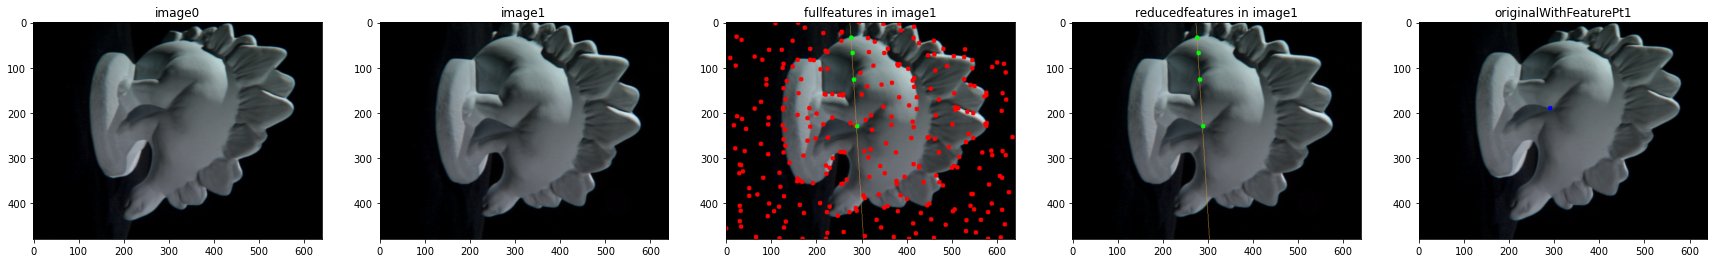

2


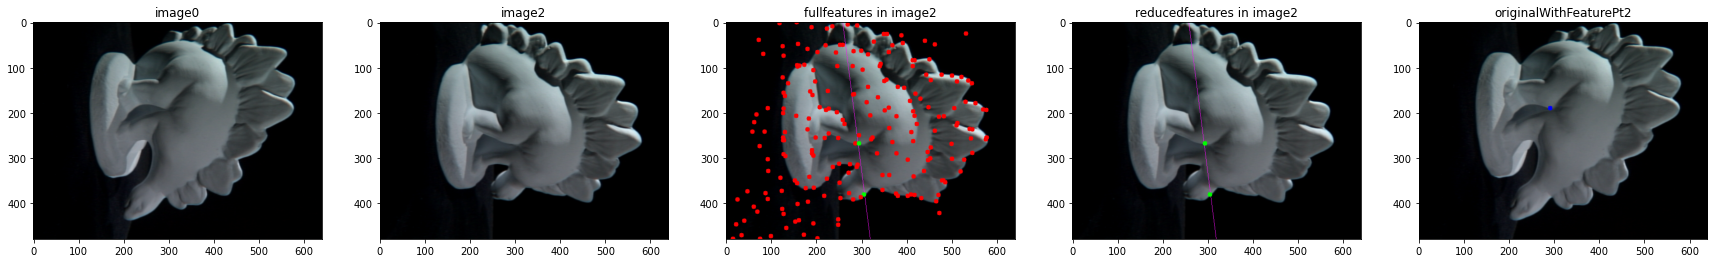

13


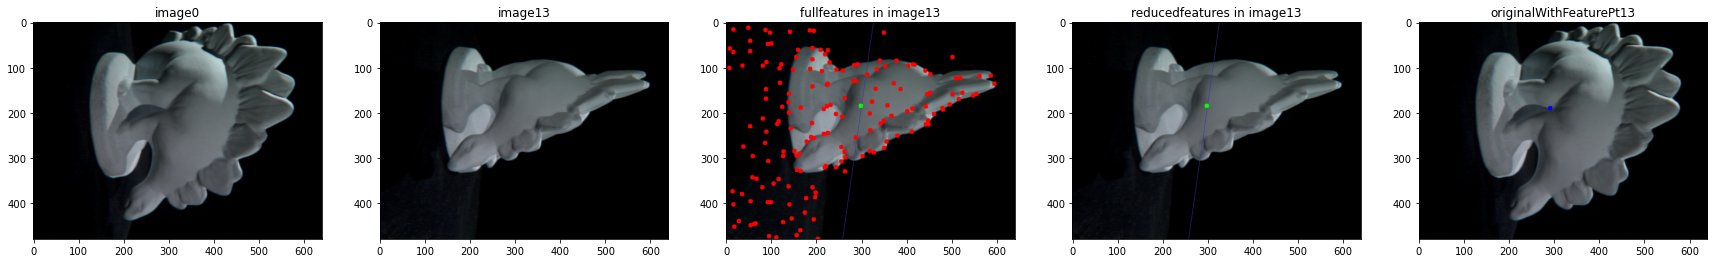

14


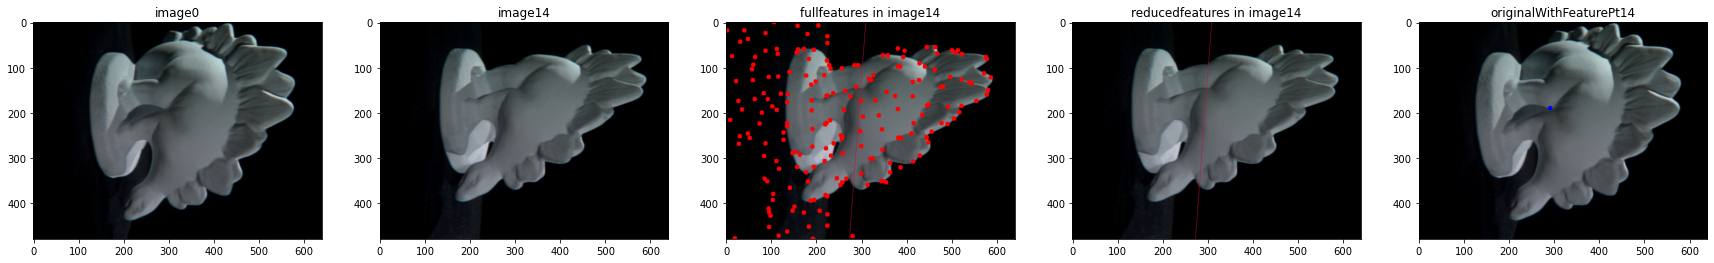

triangulations:  1 ptx 290.0 pty 230.0 0.0008304186417802395
triangulations:  2 ptx 294.0 pty 268.0 0.0014240802524408958
triangulations:  1 ptx 283.0 pty 127.0 0.004892364441527186
triangulations:  13 ptx 298.0 pty 185.0 0.006486162090841963
triangulations:  1 ptx 280.0 pty 68.0 0.007203770688949618
triangulations:  1 ptx 277.0 pty 34.0 0.008534023169724514
triangulations:  2 ptx 305.0 pty 381.0 0.010842938064949181


In [12]:
triangulations = list()
baseImageIdx = 0
for i in range(len(imagesModels[baseImageIdx]["releventImgs"])):
    releventImageIdx = imagesModels[baseImageIdx]["releventImgs"][i]
    print(releventImageIdx)
    fundmentalMat = get_fundmental_matrix(imagesModels[baseImageIdx],imagesModels[releventImageIdx])
 
    if fundmentalMat is None:
        continue
    pt1 = imagesModels[baseImageIdx]["dogPositions"][100]
    pts1 = np.int32([pt1])
    pts2 = np.int32(imagesModels[releventImageIdx]["dogPositions"])
    
    originalWithFeaturePt = imagesModels[baseImageIdx]["image"].copy()
    cv.circle(originalWithFeaturePt,tuple(pt1),5,(0,0,255),-1)
    
    # Get the epilines of features in left image on the right image
    # parameter1: points required to get its epilines in the other image
    # parameter2: which image that points are belong, 1-left 2-right
    # parameter3: fundmental matrix between the 2 images
    # returns list of epilines that lie on the other image and corresponding to the points
    lines = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,fundmentalMat)
    lines = lines.reshape(-1,3)
    #sara_im = plot_epipolar_line(imagesModels[i]["image"],fundmentalMat,[pt1[0],pt1[1],1])

    # draw the epiline on the other image
    # parameter1: the second image
    # parameter2: the epilines that lie on the second image
    # parameter3: the features lie on the second image
    fullFeaturesImage,reducedFeaturesImage,legalFeatures = drawlines(imagesModels[releventImageIdx],lines,pts2)
    
    #Triangulation
    for j in range(len(legalFeatures)):
        triangulatedPointsHomogeneous = cv.triangulatePoints(imagesModels[baseImageIdx]["projMat"],imagesModels[releventImageIdx]["projMat"],pt1,legalFeatures[j])
        triangulatedPoint = triangulatedPointsHomogeneous[:3, :] / triangulatedPointsHomogeneous[3, :]
        #triangulatedPoint = triangulate_point(np.array([pt1[0], pt1[1],1]),legalFeatures[j],imagesModels[baseImageIdx]["projMat"],imagesModels[i]["projMat"])
        
        distFromcenter = abs(abs(np.linalg.norm(np.array(imagesModels[baseImageIdx]["optCenter"][:-1]) - np.array([triangulatedPoint[0][0], triangulatedPoint[1][0], triangulatedPoint[2][0]]))) - abs(np.linalg.norm(np.array(imagesModels[releventImageIdx]["optCenter"][:-1]) - np.array([triangulatedPoint[0][0], triangulatedPoint[1][0], triangulatedPoint[2][0]]))))

        triangulation = {
            "referenceImg": baseImageIdx,
            "originalImg": releventImageIdx,
            "patchCenter": triangulatedPoint,
            "distFromCenter": distFromcenter,
            "ptx": legalFeatures[j][0],
            "pty": legalFeatures[j][1]
        }
        
        triangulations.append(triangulation)

    show_images([imagesModels[baseImageIdx]["image"],imagesModels[releventImageIdx]["image"],fullFeaturesImage,reducedFeaturesImage, originalWithFeaturePt],["image"+str(baseImageIdx),"image"+str(releventImageIdx),"fullfeatures in image"+str(releventImageIdx),"reducedfeatures in image"+str(releventImageIdx), "originalWithFeaturePt"+str(releventImageIdx)])

triangulations = sorted(triangulations, key=lambda k: k["distFromCenter"]) 
for i in range(len(triangulations)):
    print("triangulations: ", triangulations[i]["originalImg"], "ptx", triangulations[i]["ptx"], "pty", triangulations[i]["pty"], triangulations[i]["distFromCenter"])

In [ ]:
baseOptCenter = imagesModels[baseImageIdx]["optCenter"]
for candidate in triangulations:

    normalVector = np.float32([
            baseOptCenter[0] - candidate["patchCenter"][0],
            baseOptCenter[1] - candidate["patchCenter"][1],
            baseOptCenter[2] - candidate["patchCenter"][2]
        ])
    normalVector = normalVector / np.linalg.norm(direction)
    candidate["normalVector"] = normalVector

    tImgs = []

    for releventImage in triangulations:
        if otherCandidate is candidate:
            continue
        
        otherImgIdx = otherCandidate["originalImage"]
        otherNormal = np.float32([
            baseOptCenter[0] - candidate["patchCenter"][0],
            baseOptCenter[1] - candidate["patchCenter"][1],
            baseOptCenter[2] - candidate["patchCenter"][2]
        ])
        
